In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

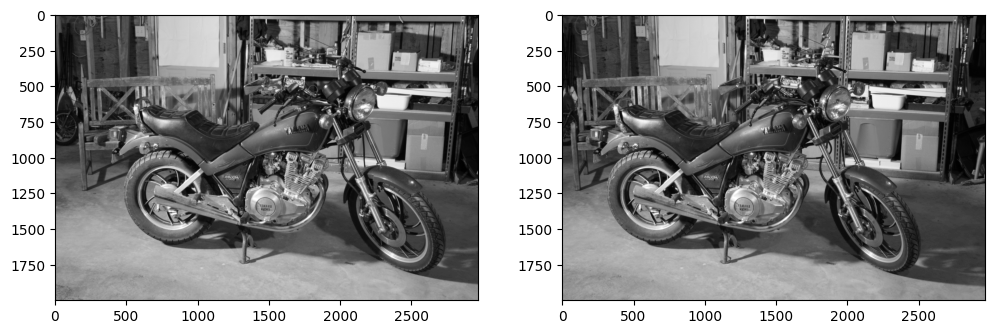

In [25]:
imgL = cv.imread(r"D:\Graphic\im0.png", 0)
imgR = cv.imread(r"D:\Graphic\im1.png", 0)

imgL = cv.GaussianBlur(imgL, (5,5), 0)
imgR = cv.GaussianBlur(imgR, (5,5), 0)

plt.figure(figsize=[12,8])
plt.subplot(121);plt.imshow(imgL, cmap='gray')
plt.subplot(122);plt.imshow(imgR, cmap='gray')

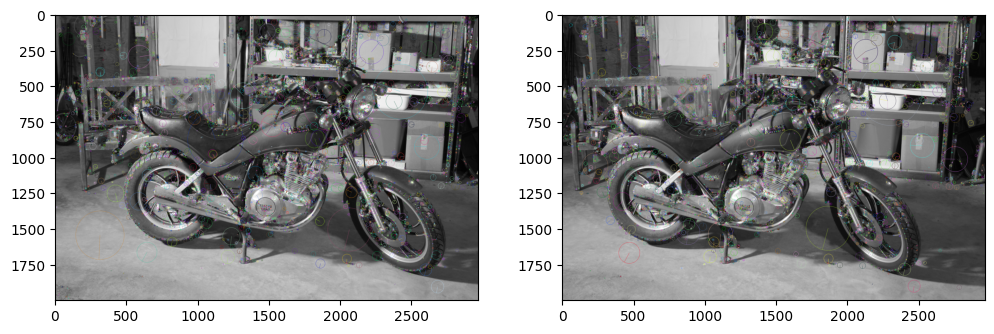

In [26]:
# Detecting key points

sift = cv.SIFT_create()
key_point1, des1 = sift.detectAndCompute(imgL, None)
key_point2, des2 = sift.detectAndCompute(imgR, None)

imgsift1 = cv.drawKeypoints(imgL, key_point1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgsift2 = cv.drawKeypoints(imgR, key_point2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=[12,8])
plt.subplot(121);
plt.imshow(imgsift1)
plt.subplot(122);plt.imshow(imgsift2)

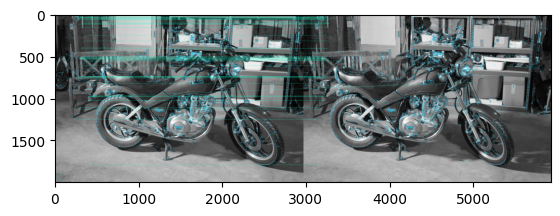

In [27]:
# Matching The keypoints

Flann_index_Kdtree = 1
index_params = dict(algorithm=Flann_index_Kdtree, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

matchesmask = [[0,0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m,n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesmask[i] = [1,0]
        good.append(m)
        pts1.append(key_point1[m.queryIdx].pt)
        pts2.append(key_point2[m.trainIdx].pt)
        
draw_params = dict(matchColor=(0,255,200), singlePointColor=(0,200,255), matchesMask=matchesmask[300:500], flags=cv.DrawMatchesFlags_DEFAULT)
keypoint_matches = cv.drawMatchesKnn(imgL,key_point1,imgR,key_point2,matches[300:500], None, **draw_params)

plt.imshow(keypoint_matches)

In [28]:
# stereo Rec ----> calc fund matrix

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliners = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)

pts1 = pts1[inliners.ravel()==1]
pts2 = pts2[inliners.ravel()==1]
print(fundamental_matrix)
print()
print(inliners)
print(type(inliners))

[[ 2.68751922e-08  1.59869027e-05 -1.05460094e-02]
 [-1.51791711e-05  8.31078716e-07  3.57265703e-01]
 [ 9.36205924e-03 -3.57505985e-01  1.00000000e+00]]

[[0]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]
<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Epilines')

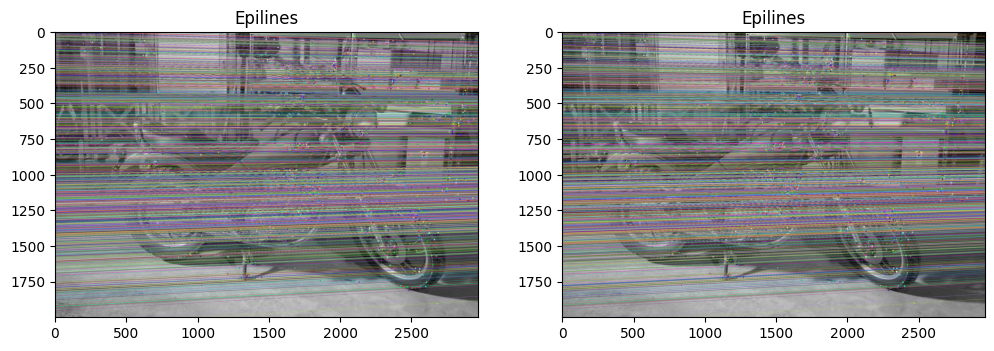

In [29]:
# epilines

def drawlines(imgL_source, imgR_source, lines, pts1_source, pts2_source):
    x, y = imgL_source.shape
    imgLcolor = cv.cvtColor(imgL_source, cv.COLOR_GRAY2BGR)
    imgRcolor = cv.cvtColor(imgR_source, cv.COLOR_GRAY2BGR)
    
    np.random.seed(0)
    
    for x, pt1, pt2, in zip(lines, pts1_source, pts2_source):
        color=tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -x[2]/x[1]])
        x1,y1 = map(int, [y, -(x[2]+x[0]*y)/x[1]])
        
        imgLcolor = cv.line(imgLcolor, (x0,y0), (x1,y1), color, 1)
        imgLcolor = cv.circle(imgLcolor, tuple(pt1), 5, color, -1)
        imgRcolor = cv.circle(imgRcolor, tuple(pt2), 5, color, -1)
        
    return imgLcolor, imgRcolor

lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2),2,fundamental_matrix)
lines1 = lines1.reshape(-1,3)
imgL_ep1, imgR_ep1 = drawlines(imgL, imgR, lines1, pts1, pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2),1,fundamental_matrix)
lines2 = lines2.reshape(-1,3)
imgR_ep2, imgL_ep2 = drawlines(imgR, imgL, lines2, pts2, pts1)

plt.figure(figsize=[12,8])
plt.subplot(121);plt.imshow(imgL_ep1);plt.title("Epilines")
plt.subplot(122);plt.imshow(imgR_ep2);plt.title("Epilines")

In [30]:
# Stereo Rec ----> uncal var
# Hemo matrix

h1, w1 = imgL.shape
h2, w2 = imgR.shape

_, H1, H2 = cv.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1,h1))

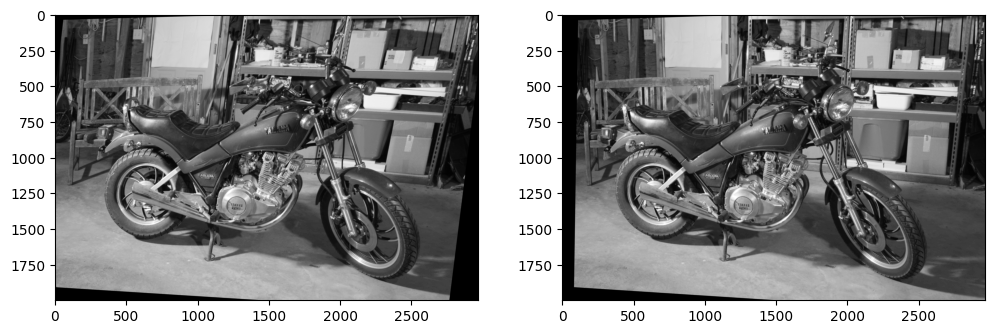

In [31]:
imgL_rec = cv.warpPerspective(imgL, H1, (w1,h1))
imgR_rec = cv.warpPerspective(imgR, H2, (w2,h2))
plt.figure(figsize=[12,8])
plt.subplot(121);plt.imshow(imgL_rec, cmap='gray')
plt.subplot(122);plt.imshow(imgR_rec, cmap='gray')

True

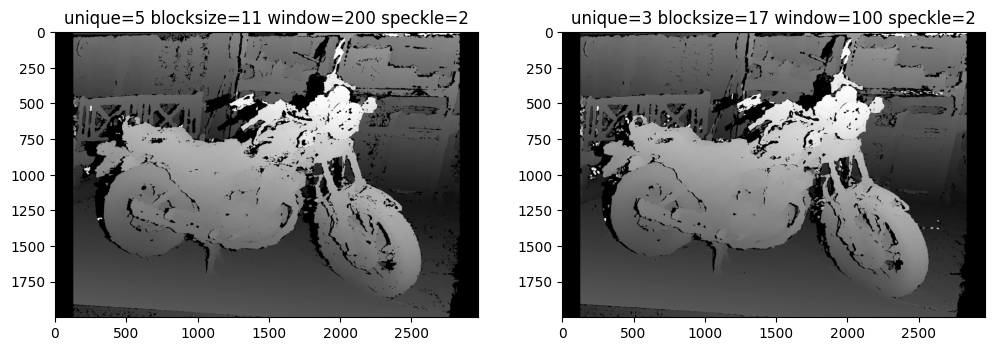

In [32]:
# Desparity map

block_size = 11
min_disp = -128
max_disp = 128

num_disp = max_disp - min_disp

stereo = cv.StereoSGBM_create(minDisparity=min_disp, numDisparities=num_disp,
                             blockSize=11, uniquenessRatio=5, speckleWindowSize=200,
                             speckleRange=2, disp12MaxDiff=0, P1=8*1*block_size*block_size,
                             P2=32*1*block_size*block_size)

disparity_SGBM1 = stereo.compute(imgL_rec, imgR_rec)

disparity_SGBM1 = cv.normalize(disparity_SGBM1, disparity_SGBM1, 255, 0,
                              norm_type=cv.NORM_MINMAX)
disparity_SGBM1 = np.uint8(disparity_SGBM1)

stereo2 = cv.StereoSGBM_create(minDisparity=min_disp, numDisparities=num_disp,
                             blockSize=17, uniquenessRatio=3, speckleWindowSize=100,
                             speckleRange=2, disp12MaxDiff=0, P1=8*1*block_size*block_size,
                             P2=32*1*block_size*block_size)

disparity_SGBM2 = stereo2.compute(imgL_rec, imgR_rec)

disparity_SGBM2 = cv.normalize(disparity_SGBM2, disparity_SGBM2, 255, 0,
                              norm_type=cv.NORM_MINMAX)
disparity_SGBM2 = np.uint8(disparity_SGBM2)


plt.figure(figsize=[12,8])
plt.subplot(121);plt.imshow(disparity_SGBM1, cmap='gray');plt.title("unique=5 blocksize=11 window=200 speckle=2")
plt.subplot(122);plt.imshow(disparity_SGBM2, cmap='gray');plt.title("unique=3 blocksize=17 window=100 speckle=2")
cv.imwrite("disp1.png", disparity_SGBM1)
cv.imwrite("disp2.png", disparity_SGBM2)

C:\Users\Asus\AppData\Local\Temp\ipykernel_2012\2277404003.py:5: RuntimeWarning: divide by zero encountered in divide
  depth1 = (b*f)/disparity_SGBM1
C:\Users\Asus\AppData\Local\Temp\ipykernel_2012\2277404003.py:6: RuntimeWarning: divide by zero encountered in divide
  depth2 = (b*f)/disparity_SGBM2


Text(0.5, 1.0, 'SGBM2')

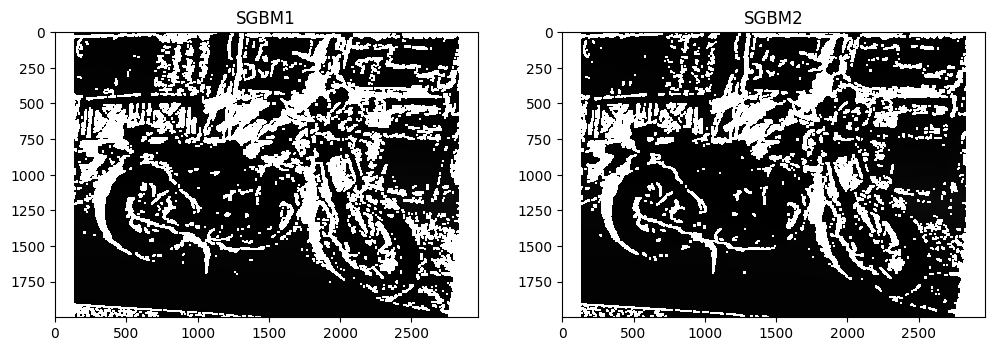

In [33]:
# Calc depth

b = 193.001
f = 3997.684
depth1 = (b*f)/disparity_SGBM1
depth2 = (b*f)/disparity_SGBM2
plt.figure(figsize=[12,8])
plt.subplot(121);
plt.imshow(depth1, cmap='gray');plt.title("SGBM1")
plt.subplot(122);plt.imshow(depth2, 'gray');plt.title("SGBM2")

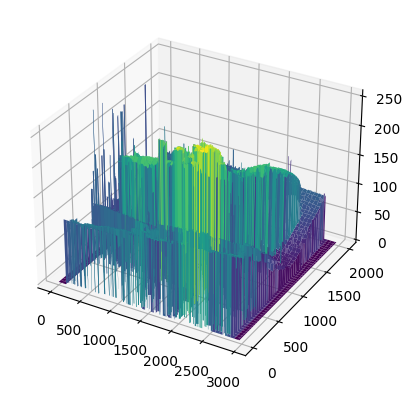

In [34]:
# 3D plot from depth map
from scipy.spatial import Delaunay
from skimage import measure
from skimage.measure import marching_cubes

x = np.arange(0, disparity_SGBM2.shape[1])
y = np.arange(0, disparity_SGBM2.shape[0])

X,Y = np.meshgrid(x,y)

Z = disparity_SGBM2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()
